In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Download ETH price data from Yahoo Finance
df = yf.download('ETH-USD', start='2019-01-01', end='2024-01-01')
df['Date'] = df.index
df.set_index('Date', inplace=True)
data = df['Close'].values.reshape(-1, 1)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,133.418152,141.397507,132.650711,140.819412,140.819412,2258709868
2019-01-02,141.519516,156.929138,140.650955,155.047684,155.047684,3328240369
2019-01-03,155.196045,155.863052,147.198364,149.135010,149.135010,2676164880
2019-01-04,148.912888,156.878983,147.907104,154.581940,154.581940,3126192535
2019-01-05,154.337418,160.824890,154.337418,155.638596,155.638596,3338211928


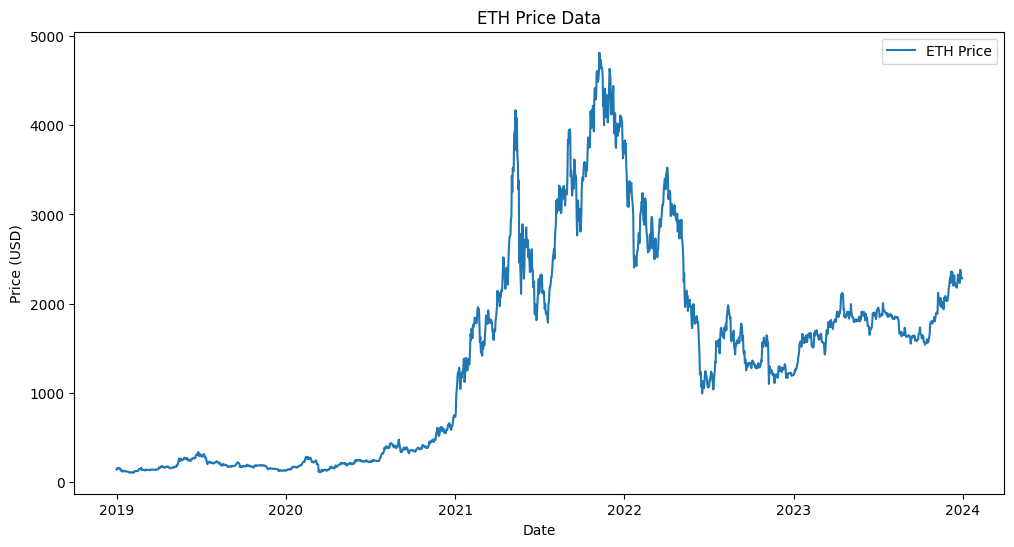

In [ ]:
# Plot raw ETH price data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='ETH Price')
plt.title('ETH Price Data')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

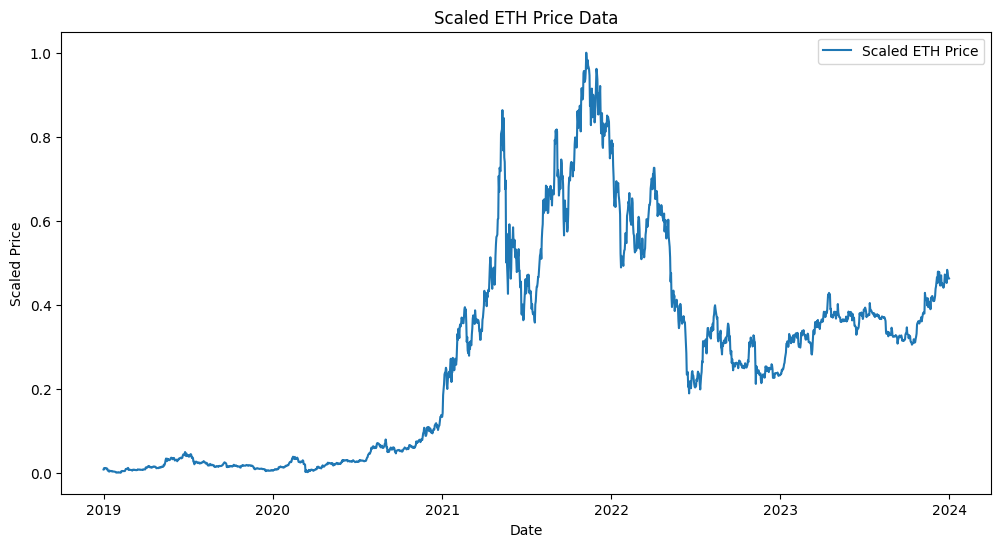

In [ ]:
# Plot scaled data
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaled_data, label='Scaled ETH Price')
plt.title('Scaled ETH Price Data')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

In [ ]:
# Split data into training and testing sets
train_size = len(scaled_data) - 365 * 2  # Last 2 years for testing
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

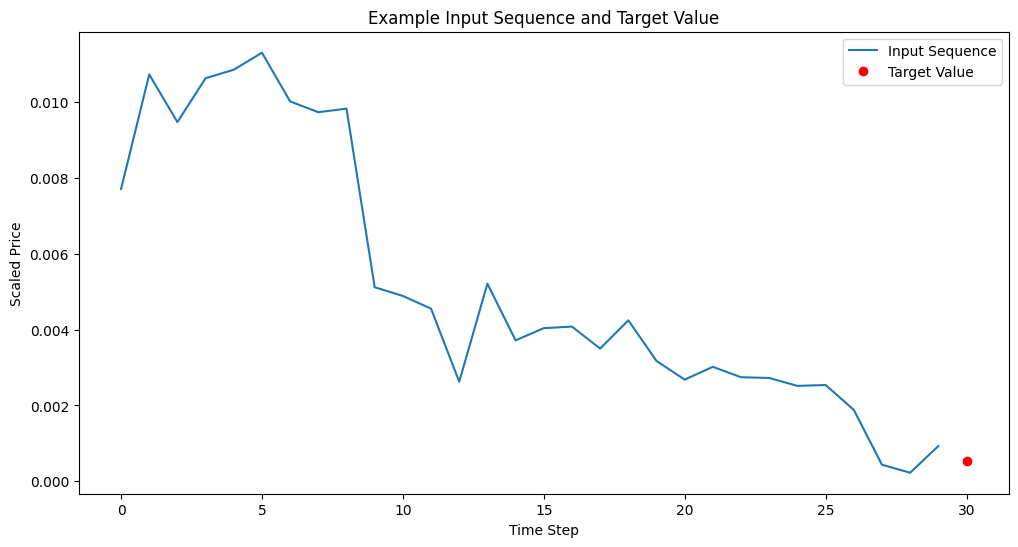

In [ ]:
# Plot example sequence
plt.figure(figsize=(12, 6))
plt.plot(range(seq_length), X_train[0], label='Input Sequence')
plt.plot(seq_length, y_train[0], 'ro', label='Target Value')
plt.title('Example Input Sequence and Target Value')
plt.xlabel('Time Step')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

In [ ]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).requires_grad_()
        lstm_out, _ = self.lstm(x, (h_0.detach(), c_0.detach()))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [ ]:
# Instantiate model, define loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the model
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

Epoch 1/100, Loss: 0.16594596470103545
Epoch 2/100, Loss: 0.06694605530184858
Epoch 3/100, Loss: 0.03500840517089648
Epoch 4/100, Loss: 0.0076839863185716025
Epoch 5/100, Loss: 0.003857610815697733
Epoch 6/100, Loss: 0.002127343288841931
Epoch 7/100, Loss: 0.0015291151939891279
Epoch 8/100, Loss: 0.0013749369091409095
Epoch 9/100, Loss: 0.0013738172471194582
Epoch 10/100, Loss: 0.0012091427377206
Epoch 11/100, Loss: 0.0011533343503662549
Epoch 12/100, Loss: 0.0011640737682361813
Epoch 13/100, Loss: 0.0010967659421593828
Epoch 14/100, Loss: 0.001060753850170466
Epoch 15/100, Loss: 0.0010639190012999974
Epoch 16/100, Loss: 0.001155256261186236
Epoch 17/100, Loss: 0.0014365106026696809
Epoch 18/100, Loss: 0.0011500734407865606
Epoch 19/100, Loss: 0.0009571764847565004
Epoch 20/100, Loss: 0.0009427965337903623
Epoch 21/100, Loss: 0.000928932657081853
Epoch 22/100, Loss: 0.0008949158655013889
Epoch 23/100, Loss: 0.0008740366080447155
Epoch 24/100, Loss: 0.0008918514666969285
Epoch 25/100, L

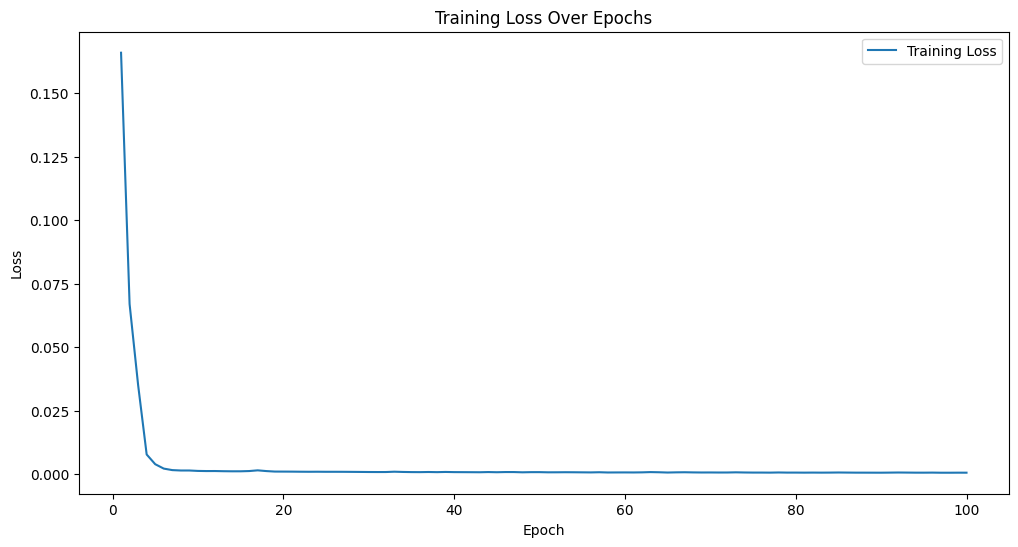

In [ ]:
# Plot training loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluating the model on test data
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        test_predictions.append(y_pred.numpy())
        test_targets.append(y_batch.numpy())

test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

In [ ]:
# Inverse transform the predictions and targets
test_predictions = scaler.inverse_transform(test_predictions)
test_targets = scaler.inverse_transform(test_targets)

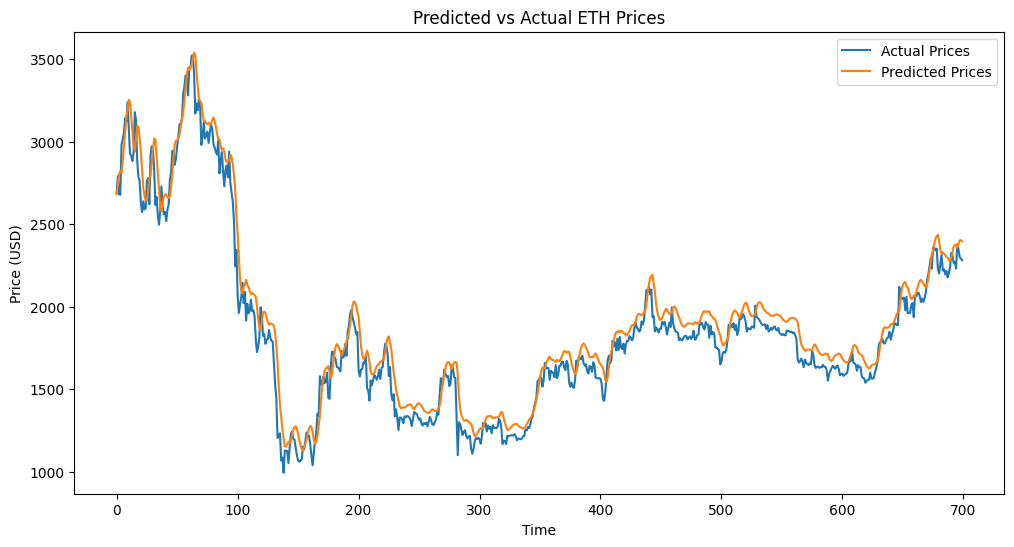

In [ ]:
# Plot predicted vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_targets)), test_targets, label='Actual Prices')
plt.plot(range(len(test_predictions)), test_predictions, label='Predicted Prices')
plt.title('Predicted vs Actual ETH Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Making future predictions
with torch.no_grad():
    test_inputs = scaled_data[-seq_length:].reshape(1, -1, 1)
    test_inputs = torch.from_numpy(test_inputs).float()
    future_pred = model(test_inputs).numpy()
    future_pred = scaler.inverse_transform(future_pred)
    print(f'Predicted ETH price: {future_pred[0][0]}')

Predicted ETH price: 2383.066650390625
